In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
cols_num = ['pclass', 'age', 'sibsp', 'parch', 'fare']
cols_cat = ['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
cols_all = cols_cat + cols_num

In [5]:
df['class'].unique()

[Third, First, Second]
Categories (3, object): [Third, First, Second]

In [6]:
train, test = train_test_split(df, test_size=0.3)


In [7]:
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/diamonds.csv')


In [11]:
x1 = train.age # train.loc[train.who=='man', 'age']
x2 = test.age #test.loc[test.who=='man', 'age']


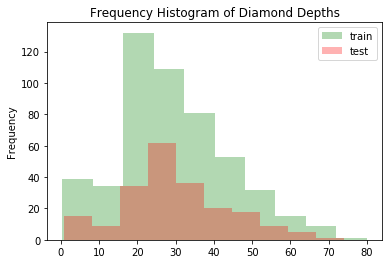

In [13]:
kwargs = dict(alpha=0.3, bins=10)
plt.hist(x1, **kwargs, color='g', label='train')
plt.hist(x2, **kwargs, color='r', label='test')
plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.xlim(50,75)
plt.legend();

# Categorical PSI

In [114]:
def calculate_psi_categorical(actual, expected):
    actual = actual.dropna()
    expected = expected.dropna()
    
    actual_perc = actual.value_counts() / len(actual)
    expected_perc = expected.value_counts() / len(expected)
    actual_classes = list(actual_perc.index)
    expected_classes = list(expected_perc.index)
    PSI = 0
    classes = set(actual_classes + expected_classes)
    for c in classes:
        final_actual_perc = actual_perc[c] if c in actual_classes else 0.00001
        final_expected_perc = expected_perc[c] if c in expected_classes else 0.00001
        
        diff = final_actual_perc - final_expected_perc
        ratio = round(final_actual_perc,6) / round(final_expected_perc,6)
        
        if c == 'G':
            G_final_actual_perc = final_actual_perc
            G_final_expected_perc = final_expected_perc

        #print(c,'final_actual_perc', final_actual_perc, 'final_expected_perc', final_expected_perc)

        PSI += diff * np.log(ratio)

    return PSI, G_final_actual_perc, G_final_expected_perc


In [115]:
mypsi, g_actual, g_expected = calculate_psi_categorical(train.deck, test.deck)

F final_actual_perc 0.08391608391608392 final_expected_perc 0.016666666666666666
B final_actual_perc 0.2517482517482518 final_expected_perc 0.18333333333333332
G final_actual_perc 0.027972027972027972 final_expected_perc 0.0
C final_actual_perc 0.2517482517482518 final_expected_perc 0.38333333333333336
A final_actual_perc 0.06293706293706294 final_expected_perc 0.1
D final_actual_perc 0.16083916083916083 final_expected_perc 0.16666666666666666
E final_actual_perc 0.16083916083916083 final_expected_perc 0.15


c:\users\cu171eg\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


In [109]:
g_actual / g_expected

c:\users\cu171eg\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


inf

In [113]:
g_expected

0.0

# Numerical PSI

In [58]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

c:\users\cu171eg\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
c:\users\cu171eg\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
c:\users\cu171eg\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


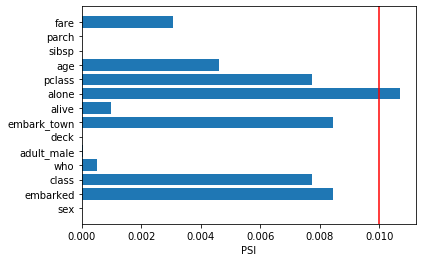

In [59]:
psis = []

#Using the above implementation to compute PSI's categorical feature
for feature_name in cols_cat:
    psi = calculate_psi_categorical(train[feature_name], test[feature_name])
    psis.append(psi)

#Using the github implementation to compute PSI's numerical features
for feature_name in cols_num:
    psi = calculate_psi(train[feature_name], test[feature_name], buckettype='quantiles', buckets=3, axis=0)
    psis.append(psi)

#Plot each feature's PSI value
height = psis
bars = cols_cat + cols_num
y_pos = np.arange(len(bars))

plt.barh(y_pos, height)
plt.axvline(x=0.01,color='red')
plt.yticks(y_pos, bars)
plt.xlabel("PSI")
plt.show()


In [60]:
def data_drift(df1, df2, categoricals, numericals):
    results = []

    # PSI for categorical feature
    for feature_name in categoricals:
        psi = calculate_psi_categorical(df1[feature_name], df2[feature_name])
        print('--> categorical', feature_name, psi)
        results.append([feature_name, 'categorical', psi])

    # PSI for numerical
    for feature_name in numericals:
        psi = calculate_psi(df1[feature_name], df2[feature_name], buckettype='quantiles', buckets=3, axis=0)
        print('--> numerical', feature_name, psi)
        results.append([feature_name, 'numerical', psi])
    
    return results

In [61]:
results = data_drift(train, test, cols_cat, cols_num)

--> categorical sex 2.491373911370726e-05
--> categorical embarked 0.008433500913154793
--> categorical class 0.007720193443539445
--> categorical who 0.0005069358316704259
--> categorical adult_male 3.237676056696344e-05
--> categorical deck inf
--> categorical embark_town 0.008433500913154793
--> categorical alive 0.000994026024782655
--> categorical alone 0.01070547480388202
--> numerical pclass 0.007720193443539445
--> numerical age 0.004624150308806509
--> numerical sibsp 0.0
--> numerical parch 0.0
--> numerical fare 0.0030676249541438903


c:\users\cu171eg\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
c:\users\cu171eg\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [62]:
pd.DataFrame(results, columns=['feature', 'type', 'PSI'])


,feature,type,PSI
0,sex,categorical,0.000025
1,embarked,categorical,0.008434
2,class,categorical,0.007720
3,who,categorical,0.000507
4,adult_male,categorical,0.000032
5,deck,categorical,inf
6,embark_town,categorical,0.008434
7,alive,categorical,0.000994
8,alone,categorical,0.010705
9,pclass,numerical,0.007720


In [63]:
train.deck.value_counts()

C    36
B    36
E    23
D    23
F    12
A     9
G     4
Name: deck, dtype: int64

In [56]:
train.deck.name

'deck'